# Simulate QSO spectra.

The purpose of this notebook is to simulate a bunch of QSO spectra using [simqso](https://github.com/moustakas/simqso) and the default (PCA-based) QSO template-generating code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

In [2]:
from desisim.templates import SIMQSO, QSO

In [3]:
import multiprocessing
nproc = multiprocessing.cpu_count() // 2

In [4]:
plt.style.use('seaborn-talk')
%matplotlib inline

### Specify the random seed and the magnitude and redshift priors.

In [5]:
seed = 1
rand = np.random.RandomState(seed)

In [6]:
nmodel = 100
mag = rand.uniform(18, 20, nmodel) # r-band
redshift = rand.uniform(2, 4, nmodel)

In [7]:
minwave, maxwave = 2500, 10e4

#### Generate spectra using both SIMQSO() and QSO().

In [8]:
simqso = SIMQSO(minwave=minwave, maxwave=maxwave, cdelt=2.0)

ToDo: Update to LegacySurvey filters!! What is 1450?


In [9]:
%time flux, wave, meta = simqso.make_templates(nmodel, seed=seed, redshift=redshift, mag=mag, nocolorcuts=True)

Need to be able to input apparent magnitudes and random seed.
simulating  100  quasar spectra
units are  flux
buildSpectra iteration  1  out of  5
--> delta mag mean = -0.2700623, rms = 0.1112007, |max| = 0.6751676
buildSpectra iteration  2  out of  5
--> delta mag mean = -0.0346213, rms = 0.0284103, |max| = 0.1212580
buildSpectra iteration  3  out of  5
--> delta mag mean = -0.0017506, rms = 0.0021316, |max| = 0.0104329
buildSpectra iteration  4  out of  5
--> delta mag mean = -0.0001022, rms = 0.0001608, |max| = 0.0009049
CPU times: user 4.14 s, sys: 108 ms, total: 4.25 s
Wall time: 4.28 s


In [10]:
meta

OBJTYPE,SUBTYPE,TEMPLATEID,SEED,REDSHIFT,MAG,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,OIIFLUX,HBETAFLUX,EWOII,EWHBETA,D4000,VDISP,OIIDOUBLET,OIIIHBETA,OIIHBETA,NIIHBETA,SIIHBETA,ZMETAL,AGE,TEFF,LOGG,FEH
,,,,,,nanomaggies,nanomaggies,nanomaggies,nanomaggies,nanomaggies,erg / (cm2 s),erg / (cm2 s),Angstrom,Angstrom,,km / s,,dex,dex,dex,dex,,Gyr,K,m / s2,
str10,str10,int64,int64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
QSO,LYA,0,1791095845,2.65328980354,18.8340440094,26.2841,29.2673,31.1931,43.1705,62.1106,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
QSO,LYA,1,4282876139,3.05411620452,19.4406489869,14.2738,16.7394,17.898,36.2353,54.3943,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
QSO,LYA,2,3093770124,3.77188419862,18.0002287496,21.4626,63.0824,82.4325,328.406,370.264,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
QSO,LYA,3,4005303368,2.71453952,18.6046651453,27.7628,36.1521,47.0104,124.457,191.847,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
QSO,LYA,4,491263,3.81707030184,18.2935117816,18.159,48.1499,53.0653,117.136,106.14,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
QSO,LYA,5,550290313,3.24672023158,18.1846771895,38.674,53.2267,61.4293,153.684,203.442,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
QSO,LYA,6,1298508491,2.03164248569,18.3725204228,40.5748,44.7705,64.9927,129.848,189.299,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
QSO,LYA,7,4290846341,3.85887446749,18.6911214541,12.2553,33.385,40.5098,94.5733,90.568,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [11]:
qso = QSO(minwave=minwave, maxwave=maxwave, cdelt=2.0)

In [12]:
%time qflux, _, qmeta = qso.make_templates(nmodel, seed=seed, redshift=redshift, mag=mag, nocolorcuts=True)

CPU times: user 11.2 s, sys: 1.89 s, total: 13.1 s
Wall time: 13.2 s


In [13]:
def compare_templates(nplot=12, ncol=4, xlim=None):
    """Plot a random sampling of the basis templates."""
    
    if xlim is None:
        xlim = (2500, 6000)
    
    nspec, npix = flux.shape
    nrow = np.ceil(nplot / ncol).astype('int')
    these = rand.choice(nspec, nplot, replace=False)
    these = np.sort(these)

    fig, ax = plt.subplots(nrow, ncol, figsize=(3*ncol, 2.5*nrow), sharey=False, sharex=True)
    for ii, (thisax, indx) in enumerate(zip(ax.flat, these)):
        thisax.plot(wave, flux[indx, :], label='SIMQSO')
        thisax.plot(wave, qflux[indx, :], alpha=0.7, label='QSO')
        thisax.xaxis.set_major_locator(plt.MaxNLocator(3))
        thisax.set_xlim(xlim)
        ww = (wave > xlim[0]) * (wave < xlim[1])
        ylim = (flux[indx, ww].min(), flux[indx, ww].max())
        thisax.set_ylim(ylim)
        thisax.yaxis.set_ticklabels([])
        if xlim[1] > 1e4:
            thisax.set_xscale('log')
            thisax.set_yscale('log')
        if ii == 0:
            thisax.legend(loc='upper left')
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

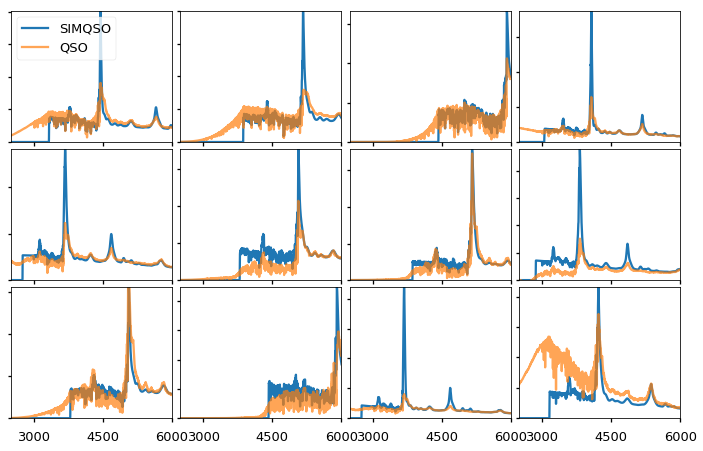

In [14]:
compare_templates()

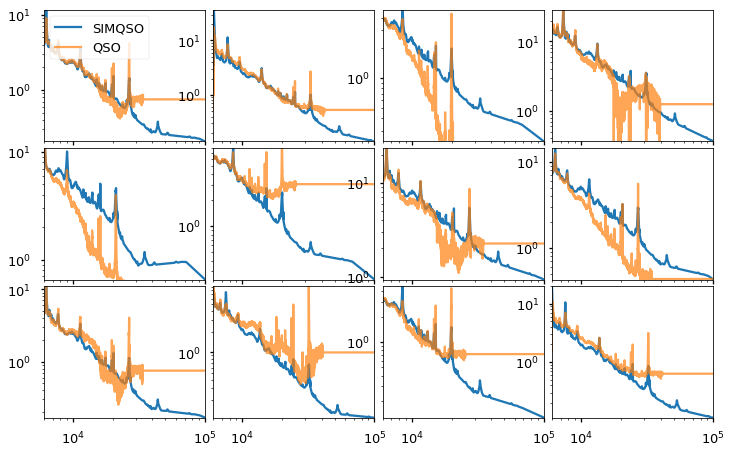

In [15]:
compare_templates(xlim=(6000, maxwave))

### Compare the two template sets in color-color and color-redshift space.

In [16]:
def flux2colors(cat):
    """Convert DECam/WISE fluxes to magnitudes and colors."""
    colors = dict()
    #with warnings.catch_warnings(): # ignore missing fluxes (e.g., for QSOs)
    #    warnings.simplefilter('ignore')
    colors['g'] = 22.5 - 2.5 * np.log10(cat['FLUX_G'])
    colors['r'] = 22.5 - 2.5 * np.log10(cat['FLUX_R'])
    colors['z'] = 22.5 - 2.5 * np.log10(cat['FLUX_Z'])
    colors['gr'] = colors['g'] - colors['r']
    colors['gz'] = colors['g'] - colors['z']
    colors['rz'] = colors['r'] - colors['z']
    colors['grz'] = 22.5-2.5*np.log10(cat['FLUX_G'] + 0.8 * cat['FLUX_R'] +  0.5 * cat['FLUX_G'] / 2.3)

    with np.errstate(invalid='ignore'):
        colors['W'] = 22.5-2.5*np.log10(0.75 * cat['FLUX_W1'] + 0.25 * cat['FLUX_W2'])
        colors['rW'] = colors['r'] - colors['W']
    
    return colors

In [17]:
colors = flux2colors(meta)
qcolors = flux2colors(qmeta)

In [18]:
def qso_colorbox(ax, plottype='grz'):
    """Draw the QSO selection boxes."""
    rmaglim = 22.7
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    if plottype == 'grz-r':
        verts = [(xlim[0]-0.05, 17.0),
                 (22.7, 17.0),
                 (22.7, ylim[1]+0.05),
                 (xlim[0]-0.05, ylim[1]+0.05)
                ]
    if plottype == 'rW1-rz':
        verts = None
        ax.axvline(x=-0.3, ls='--', color='k')
        ax.axvline(x=1.3, ls='--', color='k')

    if plottype == 'gr-rz':
        verts = [(-0.3, 1.3),
                 (1.1, 1.3),
                 (1.1, ylim[0]-0.05),
                 (-0.3, ylim[0]-0.05)
                ]
    if verts:
        ax.add_patch(Polygon(verts, fill=False, ls='--', color='k'))

In [19]:
def qa_colorcolor():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.scatter(colors['rz'], colors['gr'], s=14, label='SIMQSO')
    ax1.scatter(qcolors['rz'], qcolors['gr'], s=14, label='QSO')
    ax1.set_xlabel('$r - z$')
    ax1.set_ylabel('$g - r$')
    ax1.set_xlim(-1, 2.2)
    ax1.set_ylim(-1, 2.0)
    ax1.legend(loc='upper right')
    qso_colorbox(ax1, 'gr-rz')
    
    ax2.scatter(colors['gz'], colors['rW'], s=14, label='SIMQSO')
    ax2.set_xlabel('$g - z$')
    ax2.set_ylabel('$r - W$')
    ax2.set_xlim(-0.3, 2)
    ax2.set_ylim(-1, 3)
    ax2.legend(loc='upper right')
    gzaxis = np.linspace(-0.5, 2.0, 50)
    ax2.plot(gzaxis, np.polyval([1.0, -1.0], gzaxis))
    #qso_colorbox(ax1, 'gr-rz')
    plt.subplots_adjust(wspace=0.3)

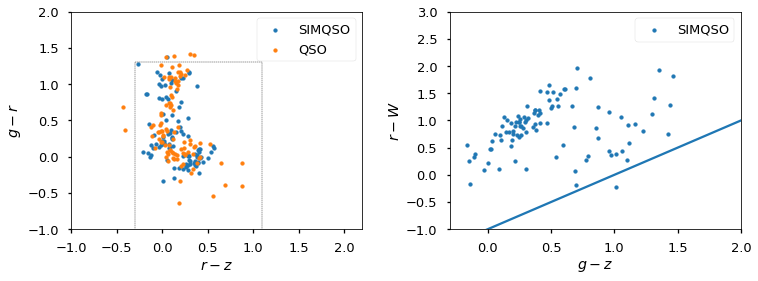

In [20]:
qa_colorcolor()